In [1]:
### Load packages

%matplotlib inline

from IPython.display import display, Image
import PIL
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from sklearn.linear_model import LogisticRegression
import sys
import tarfile

In [2]:
### Define environment variables

HOMEDIR = os.environ["HOME"]

BASEDIR = os.path.join(HOMEDIR, "workspace", "self_education", "udacity", "TensorFlowUdacity")

DATADIR = os.path.join(BASEDIR, "data")
ORIGINALDATADIR = os.path.join(DATADIR, "notmnist", "original")
SANITIZEDDATADIR = os.path.join(DATADIR, "notmnist", "sanitized")

NOTMNISTLARGEDIR = os.path.join(ORIGINALDATADIR, "notmnist_large")
NOTMNISTSMALLDIR = os.path.join(ORIGINALDATADIR, "notmnist_small")

ORIGINALDATAFILE = os.path.join(ORIGINALDATADIR, 'notmnist.pickle')
SANITIZEDDATAFILE = os.path.join(SANITIZEDDATADIR, 'notmnist.pickle')

In [3]:
### Functions for getting array of directory paths and array of file paths

def get_dir_paths(root):
  return [os.path.join(root, n) 
    for n in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, n))
  ]

def get_file_paths(root):
  return [os.path.join(root, n)
    for n in sorted(os.listdir(root))
    if os.path.isfile(os.path.join(root, n))
  ]

In [4]:
### Get directory and file paths of training and test sets

train_data_paths = get_dir_paths(NOTMNISTLARGEDIR)
test_data_paths = get_dir_paths(NOTMNISTSMALLDIR)

### Problem 1

In [5]:
## Display a sample of 5 images in their initial png format

nsamples = 5

for i in np.arange(nsamples):
  display(Image(filename=np.random.choice(get_file_paths(np.random.choice(test_data_paths)))))

In [6]:
## Set image properties

image_size = 28 # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [7]:
## Read a sample image

image_file = np.random.choice(get_file_paths(np.random.choice(test_data_paths)))
image_data = ndimage.imread(image_file).astype(float)

In [8]:
## Show type of image object

type(image_data)

numpy.ndarray

In [9]:
## Show dimensions of image object

image_data.shape

(28, 28)

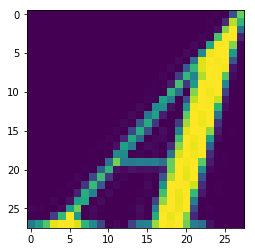

In [10]:
## Plot image using imshow

plt.imshow(image_data)
plt.show()
# display(Image(image_data))

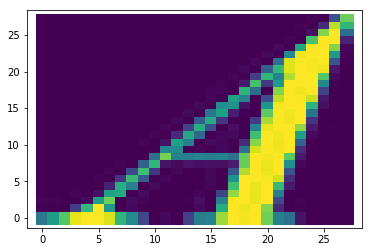

In [11]:
## Plot image using a scatterplot

colors = [str(i/pixel_depth) for i in np.ravel(image_data)]
plt.scatter(
  np.tile(np.arange(image_size), image_size),
  np.repeat(np.flipud(np.arange(image_size)), image_size),
  s=150,
  c=colors,
  marker='s'
)
plt.show()

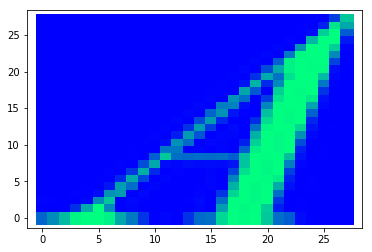

In [12]:
## Plot image using a scatterplot by setting cmap option

colors = [str(i/pixel_depth) for i in np.ravel(image_data)]
plt.scatter(
  np.tile(np.arange(image_size), image_size),
  np.repeat(np.flipud(np.arange(image_size)), image_size),
  s=150,
  c=colors,
  marker='s',
  cmap=plt.cm.winter
)
plt.show()

In [13]:
## Functions for normalizing and retrieving images

# Normalize image by pixel depth
def normalize_image(image, pixel_depth):
  return (ndimage.imread(image).astype(float)-pixel_depth/2)/pixel_depth

# Retrieve original image from normalized image
def unnormalize_image(image, pixel_depth):
  return (pixel_depth*image+pixel_depth/2).astype(np.uint8)

In [14]:
## Function for loading data for a single letter

def load_letter(root, image_size, pixel_depth, verbose=True, min_nimages=1):
  """Load data for a single letter."""

  if verbose:
    print(root)

  image_files = get_file_paths(root)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)

  image_index = 0
  for image in image_files:
    try:
      image_data = normalize_image(image, pixel_depth)
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Skipping because of not being able to read: ', image_file)

  dataset = dataset[0:image_index, :, :]
  if image_index < min_nimages:
    raise Exception('Fewer images than expected: %d < %d' % (image_index, min_nimages))

  if verbose:    
    print('Full dataset tensor: ', dataset.shape)
    print('Mean: ', np.mean(dataset))
    print('Standard deviation: ', np.std(dataset))

  return dataset

In [15]:
## Test load_letter() function by loading data for letter C

letter_data = load_letter(test_data_paths[2], image_size, pixel_depth)

/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_small/C
('Full dataset tensor: ', (1873, 28, 28))
('Mean: ', -0.14152053)
('Standard deviation: ', 0.44269028)


In [16]:
## Show dimensions of loaded data for letter C

letter_data.shape

(1873, 28, 28)

In [17]:
## Show dimensions of data for the first image of letter C

letter_data[0, :, :].shape

(28, 28)

In [18]:
## Function for generating pickle filenames

def generate_pickle_names(root):
  dataset_files = []

  for d in root:
    pickle_file = d + '.pickle'
    dataset_files.append(pickle_file)
  
  return dataset_files

In [19]:
## Function for pickling data of all letters

def pickle_letters(root, image_size, pixel_depth, verbose=True, min_nimages=1, force=False):
  pickle_files = generate_pickle_names(root)
  n = len(root)
    
  for i in np.arange(n):
    if os.path.exists(pickle_files[i]) and not force:
      print('%s already present, skipping pickling' % pickle_files[i])
    else:
      print('Pickling %s' % pickle_files[i])
      dataset = \
        load_letter(root[i], image_size, pixel_depth, verbose=verbose, min_nimages=min_nimages)
      try:
        with open(pickle_files[i], 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', pickle_files[i], ':', e)
  
  return pickle_files

In [20]:
### Pickle training set

train_files = pickle_letters(train_data_paths, image_size, pixel_depth)

/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_large/A.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_large/B.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_large/C.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_large/D.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_large/E.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_large/F.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_large/G

In [21]:
### Pickle test set

test_files = pickle_letters(test_data_paths, image_size, pixel_depth)

/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_small/A.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_small/B.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_small/C.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_small/D.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_small/E.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_small/F.pickle already present, skipping pickling
/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist_small/G

### Problem 2

In [22]:
## Test pickling by loading pickle for letter D

letter_data = np.load(os.path.join(NOTMNISTLARGEDIR, "D.pickle"))

In [23]:
## Show dimensions of data loaded from pickle of letter D

letter_data.shape

(52911, 28, 28)

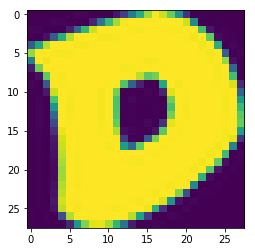

In [24]:
## Plot fifth image of letter D from loaded pickle using imshow

plt.imshow(letter_data[4, :, :])
plt.show()

### Problem 3

In [25]:
## Check if training sets are balanced across letter classes using absolute frequencies

ntrainsets = len(train_data_paths)

train_stats = np.empty(shape=ntrainsets, dtype=np.int64)

for i in np.arange(ntrainsets):
  letter_data = np.load(".".join([train_data_paths[i], "pickle"]))
  train_stats[i] = letter_data.shape[0]

train_stats

array([52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911])

In [26]:
## Check if training sets are balanced across letter classes using percentages

train_stats_perc = 100*train_stats/np.float32(sum(train_stats))

train_stats_perc

array([  9.99954641,   9.9999244 ,  10.0001134 ,   9.9999244 ,
        10.0001134 ,  10.0001134 ,  10.0001134 ,  10.0001134 ,
        10.0001134 ,   9.9999244 ])

In [27]:
## Check if test sets are balanced across letter classes using absolute frequencies

ntestsets = len(test_data_paths)

test_stats = np.empty(shape=ntestsets, dtype=np.int64)

for i in np.arange(ntrainsets):
  letter_data = np.load(".".join([test_data_paths[i], "pickle"]))
  test_stats[i] = letter_data.shape[0]

test_stats

array([1872, 1873, 1873, 1873, 1873, 1872, 1872, 1872, 1872, 1872])

In [28]:
## Check if test sets are balanced across letter classes using percentages

test_stats_perc = 100*test_stats/np.float32(sum(test_stats))

test_stats_perc

array([  9.9978637 ,  10.00320444,  10.00320444,  10.00320444,
        10.00320444,   9.9978637 ,   9.9978637 ,   9.9978637 ,
         9.9978637 ,   9.9978637 ])

In [29]:
## Function for allocating array to host all image sub-arrays into it

def allocate_image_space(nimages, image_size):
  if nimages > 0:
    dataset = np.ndarray((nimages, image_size, image_size), dtype=np.float32)
    labels = np.ndarray(nimages, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

In [30]:
## Function for merging letter images to create train, validation and test sets

def merge_images(pickle_files, image_size, ntrain, nvalidation=0):
  train_dataset, train_labels = allocate_image_space(ntrain, image_size)
  validation_dataset, validation_labels = allocate_image_space(nvalidation, image_size)

  nclasses = len(pickle_files)
  ntrain_per_class = ntrain//nclasses
  nvalidation_per_class = nvalidation//nclasses
  total_per_class = ntrain_per_class+nvalidation_per_class
  train_start, validation_start = 0, 0
  train_end, validation_end = ntrain_per_class, nvalidation_per_class

  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_data = pickle.load(f)
        
        # Shuffle the letters to have random training and validation set
        np.random.shuffle(letter_data)

        train_dataset[train_start:train_end, :, :] = letter_data[:ntrain_per_class, :, :]
        train_labels[train_start:train_end] = label
        train_start += ntrain_per_class
        train_end += ntrain_per_class
        
        if validation_dataset is not None:
          validation_dataset[validation_start:validation_end, :, :] = \
            letter_data[ntrain_per_class:total_per_class, :, :]
          validation_labels[validation_start:validation_end] = label
          validation_start += nvalidation_per_class
          validation_end += nvalidation_per_class

    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
        
  return train_dataset, train_labels, validation_dataset, validation_labels

In [31]:
## Set number of train, validation and test images

ntrain = 200000
nvalidation = 10000
ntest = 10000

In [32]:
## Generate train and validation datasets

train_dataset, train_labels, validation_dataset, validation_labels = \
  merge_images(train_files, 28, ntrain, nvalidation)

In [33]:
## Generate test dataset

test_dataset, test_labels, _, _ = merge_images(test_files, 28, ntest)

In [34]:
## Show dimensions of train, validation and test datasets

print('Training: ', train_dataset.shape, train_labels.shape)
print('Validation: ', validation_dataset.shape, validation_labels.shape)
print('Testing: ', test_dataset.shape, test_labels.shape)

('Training: ', (200000, 28, 28), (200000,))
('Validation: ', (10000, 28, 28), (10000,))
('Testing: ', (10000, 28, 28), (10000,))


In [35]:
## Function for shuffling image datasets

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation, :, :]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

In [36]:
## Shuffle train, validation and test datasets

train_dataset, train_labels = randomize(train_dataset, train_labels)
validation_dataset, validation_labels = randomize(validation_dataset, validation_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

### Problem 4

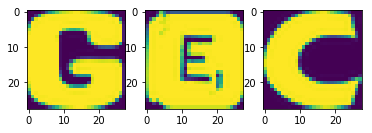

In [37]:
## Display a sample of 3 images in their initial png format

samples = np.random.choice(3, 3, replace=False)

fig = plt.figure()
gs = gridspec.GridSpec(1, 3)
fig.add_subplot(gs[0])
plt.imshow(train_dataset[samples[0], :, :])
fig.add_subplot(gs[1])
plt.imshow(train_dataset[samples[1], :, :])
fig.add_subplot(gs[2])
plt.imshow(train_dataset[samples[2], :, :])
plt.show()

In [38]:
## Count number of letters per class in shuffled train dataset using labels

np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000]))

In [39]:
## Count number of letters per class in shuffled validation dataset using labels

np.unique(validation_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [40]:
## Count number of letters per class in shuffled test dataset using labels

np.unique(test_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [41]:
## Function for saving an object to a pickle file

def save_to_pickle(pickle_file, object, force=False):
  if os.path.exists(pickle_file) and not force:
    print('%s already present, skipping pickling' % pickle_file)
  else:
    try:
      f = open(pickle_file, 'wb')
      pickle.dump(object, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save object to', pickle_file, ':', e)
      raise      

In [42]:
## Save train, validation and test datasets to pickle file

save_to_pickle(
  ORIGINALDATAFILE,
  {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'validation_dataset': validation_dataset,
    'validation_labels': validation_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
  }    
)

/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/original/notmnist.pickle already present, skipping pickling


In [43]:
## Size of picle file containing train, validation and test datasets

print('Compressed pickle size: %d' % os.stat(ORIGINALDATAFILE).st_size)

Compressed pickle size: 690800451


### Problem 5

To check whether two images are duplicates it suffices to check if their matrix representations are equal. The main limitation of this approach is that it only detecs exact duplicates. There are other methods for identifying near duplicates.

There are two main classes of methods for detecting near duplicates among images. One of these two method classes is known as image fingerprinting or image hashing. The main idea of image hashing is to construct a unique numerical value, known as image hash, from the contents of the image. The hash plays the role of a fingerprint in the sense that it uniquely identifies its associated image. Images that are “similar” should have “similar” hashes.

Another class of algorithms compares a pair of images by computing a metric of similarity based on the contents of both images. Various similarity metrics are used in practice, such as the mean squared error (MSE) or the structural similarity index (SSIM).

In this notebook, near-duplicates are found using image hashing.

#### Finding near-duplicates using image hashing

##### Difference hashing (dHash) algorithm

One potential approach to image hash creation is to make use of cryptographic hashing algorithms such as MD5 or SHA-1. However, if an image has been edited even slightly, the [avalance effect](https://en.wikipedia.org/wiki/Avalanche_effect) of the cryptographic algorithm would generate a hash for the slightly edited image very different from the hash of the original image.

For this reason, alternative hashing algorithms are used for image hashing. In what follows, the difference hashing algorithm (dHash) will be presented. dHash computes the difference in brightness between adjacent pixels. It is a simple algorithm to implement. Its main steps are the following:
1. Grayscale the image.
2. Shrink the image.
3. Compare the intensity values of adjacent pixels row-wise. Introduce a binary classification scheme to compare adjacent pixels; if the intensity value of the preceding pixel is higher than the intensity value of the succeeding pixel in the row, then label the difference between the two adjacent pixels as 1, otherwise as 0.
4. Convert the resulting binary vector of ones and zeros to a hexadecimal string, which is the image hash.

In [44]:
## Function for computing the difference hash (dHash) of an image

# The input argument hsize is the hash size
def image_dhash(image, hsize=8):
  # Grayscale and shrink the image
  icon = PIL.Image.fromarray(image).convert('L').resize((hsize+1, hsize), PIL.Image.ANTIALIAS)
  icon = np.array(icon)

  # Compare intensity values of adjacent pixels row-wise
  diff = np.empty([hsize, hsize], dtype=np.bool_)
  for row in np.arange(hsize):
    for col in np.arange(hsize):
      diff[row, col] = icon[row, col] > icon[row, col+1]

  # Convert binary vector to hexadecimal string
  hexadecimal = np.empty(hsize, dtype=np.dtype((bytes, hsize/4)))
  for i in np.arange(hsize):
    hexadecimal[i] = \
      hex(int(''.join(str(b) for b in np.flipud(diff[i, :].astype(int))), 2))[2:].rjust(2, '0')
    
  return ''.join(hexadecimal)

In [45]:
## Set hash size, which will be used for generate difference hashes of images

hash_size = 8

In [46]:
## Compute difference hashes of images in the train dataset

train_dhashes = np.empty(ntrain, dtype=np.dtype((bytes, (hash_size**2)/4)))

for i in np.arange(ntrain):
  train_dhashes[i] = image_dhash(unnormalize_image(train_dataset[i, :, :], pixel_depth))

In [47]:
## Compute difference hashes of images in the validation dataset

validation_dhashes = np.empty(nvalidation, dtype=np.dtype((bytes, (hash_size**2)/4)))

for i in np.arange(nvalidation):
  validation_dhashes[i] = \
    image_dhash(unnormalize_image(validation_dataset[i, :, :], pixel_depth))

In [48]:
## Compute difference hashes of images in the test dataset

test_dhashes = np.empty(ntest, dtype=np.dtype((bytes, (hash_size**2)/4)))

for i in np.arange(ntest):
  test_dhashes[i] = image_dhash(unnormalize_image(test_dataset[i, :, :], pixel_depth))

##### Removing near-duplicates within each of train, validation and test dataset

In [49]:
## Get locations of images in the train dataset after excluding near-duplicates

unique_train_dhashes, unique_train_locations = np.unique(train_dhashes, return_index=True)

print('Number of images in train dataset: %d' % ntrain)
print(
  'Number of images in train dataset after excluding near-duplicates: %d'
  % np.size(unique_train_locations)
)
print(
  '%.2f%% of images in train dataset kept' 
  % round(100*np.float32(np.size(unique_train_locations))/ntrain, 2)
)

Number of images in train dataset: 200000
Number of images in train dataset after excluding near-duplicates: 156007
78.00% of images in train dataset kept


In [50]:
## Get locations of images in the validation dataset after excluding near-duplicates

unique_validation_dhashes, unique_validation_locations = \
  np.unique(validation_dhashes, return_index=True)

print('Number of images in validation dataset: %d' % nvalidation)
print(
  'Number of images in validation dataset after excluding near-duplicates: %d'
  % np.size(unique_validation_locations)
)
print(
  '%.2f%% of images in validation dataset kept' 
  % round(100*np.float32(np.size(unique_validation_locations))/nvalidation, 2)
)

Number of images in validation dataset: 10000
Number of images in validation dataset after excluding near-duplicates: 9281
92.81% of images in validation dataset kept


In [51]:
## Get locations of images in the test dataset after excluding near-duplicates

unique_test_dhashes, unique_test_locations = np.unique(test_dhashes, return_index=True)

print('Total number of images in test dataset: %d' % ntest)
print(
  'Number of images in test dataset after excluding near-duplicates: %d'
  % np.size(unique_test_locations)
)
print(
  '%.2f%% of images in test dataset kept' 
  % round(100*np.float32(np.size(unique_test_locations))/ntest, 2)
)

Total number of images in test dataset: 10000
Number of images in test dataset after excluding near-duplicates: 8983
89.83% of images in test dataset kept


##### Removing near-duplicates between train, validation and test datasets

In [52]:
## Function for returning locations (array indices) of unique images between datasets
## Uniqueness of images is defined on the basis of uniqueness of dHashes
## The returned indices are a subset of scannedlocs
## scannedlocs is a subset of baselocs

def unique_image_crosslocations(scannedset, scannedlocs, baseset, baselocs):
  indices = np.array([], dtype=np.int64)

  for i in scannedlocs:
    if scannedset[i] not in baseset[baselocs]:
      indices = np.append(indices, i)

  return indices

In [53]:
## Get locations of images whose dHashes appear in train but not in test set

unique_train_locations_vs_test = unique_image_crosslocations(
  train_dhashes, unique_train_locations, test_dhashes, unique_test_locations
)

print(
  'Number of unique images within train dataset: %d'
  % np.size(unique_train_locations)
)
print(
  'Number of unique images in train dataset not in test set: %d'
  % np.size(unique_train_locations_vs_test)
)
print(
  '%.2f%% of unique images in train dataset kept' 
  % round(
    100*np.float32(np.size(unique_train_locations_vs_test))/
      np.size(unique_train_locations),
    2
  )
)

Number of unique images within train dataset: 156007
Number of unique images in train dataset not in test set: 153261
98.24% of unique images in train dataset kept


In [54]:
## Get locations of images whose dHashes appear in train only

unique_train_locations_vs_validation = unique_image_crosslocations(
  train_dhashes,
  unique_train_locations_vs_test,
  validation_dhashes,
  unique_validation_locations
)

ntrain_sanitized = np.size(unique_train_locations_vs_validation)

print(
  'Number of unique images in train set and not in test set: %d'
  % np.size(unique_train_locations_vs_test)
)
print(
  'Number of unique images in train set and not in test or validation set: %d'
  % ntrain_sanitized
)
print(
  '%.2f%% of unique images in train dataset kept' 
  % round(
    100*np.float32(ntrain_sanitized)/np.size(unique_train_locations_vs_test),
    2
  )
)
print(
  '%.2f%% of images from original train dataset kept' 
  % round(100*np.float32(np.size(unique_train_locations_vs_validation))/ntrain, 2)
)

Number of unique images in train set and not in test set: 153261
Number of unique images in train set and not in test or validation set: 151262
98.70% of unique images in train dataset kept
75.63% of images from original train dataset kept


In [55]:
## Get locations of images whose dHashes appear in validation but not in test set

unique_validation_locations_vs_test = unique_image_crosslocations(
  validation_dhashes,
  unique_validation_locations,
  test_dhashes,
  unique_test_locations
)

nvalidation_sanitized = np.size(unique_validation_locations_vs_test)
ntest_sanitized = np.size(unique_test_locations)

print(
  'Number of unique images within validation dataset: %d'
  % np.size(unique_validation_locations)
)
print(
  'Number of unique images in validation set and not in test set: %d'
  % nvalidation_sanitized
)
print(
  '%.2f%% of unique images in validation dataset kept' 
  % round(
    100*np.float32(nvalidation_sanitized)/np.size(unique_validation_locations),
    2
  )
)
print(
  '%.2f%% of images from original validation dataset kept' 
  % round(100*np.float32(nvalidation_sanitized)/nvalidation, 2)
)

Number of unique images within validation dataset: 9281
Number of unique images in validation set and not in test set: 8820
95.03% of unique images in validation dataset kept
88.20% of images from original validation dataset kept


In [56]:
## Summary of number of images in sanitized datasets

print('Number of images in original train set: %d' % ntrain)
print('Number of images in sanitized train set: %d' % ntrain_sanitized)
print(
  '%.2f%% of images from original train set kept in sanitized train set' 
  % round(100*np.float32(ntrain_sanitized)/ntrain, 2)
)

print('\n')

print('Number of images in original validation set: %d' % nvalidation)
print('Number of images in sanitized validation set: %d' % nvalidation_sanitized)
print(
  '%.2f%% of images from original validation set kept in sanitized validation set' 
  % round(100*np.float32(nvalidation_sanitized)/nvalidation, 2)
)

print('\n')

print('Number of images in original test set: %d' % ntest)
print('Number of images in sanitized test set: %d' % ntest_sanitized)
print(
  '%.2f%% of images from original test set kept in sanitized test set' 
  % round(100*np.float32(ntest_sanitized)/ntest, 2)
)

Number of images in original train set: 200000
Number of images in sanitized train set: 151262
75.63% of images from original train set kept in sanitized train set


Number of images in original validation set: 10000
Number of images in sanitized validation set: 8820
88.20% of images from original validation set kept in sanitized validation set


Number of images in original test set: 10000
Number of images in sanitized test set: 8983
89.83% of images from original test set kept in sanitized test set


##### Finding near-duplicates using Hamming distance

The dHashes of two images can be compared by calculating the Hamming distance of the dHashes, which is the count of differing characters between the two dHashes. The closer the Hamming distance to 0, the more similar the two images.

In what follows, a function for computing the Hamming distance of two dHashes of equal length and a function for finding the number of unique images between two datasets with respect to a given Hamming distance lower bound are provided for demonstration purposes. In practice, the sanitized datasets have been generated by keeping images with unique dHashes, which corresponds to the case of images whose pairwise dHashes have Hamming distance equal to the hash length (16). This choice was made for the sake of computational efficiency.

In [57]:
## Return the Hamming distance between equal-length hashes

def hamming_distance(h1, h2):
  if len(h1) != len(h2):
    raise ValueError("Undefined for hashes of unequal length")

  return sum(c1 != c2 for c1, c2 in zip(h1, h2))

In [58]:
## Function for returning locations (array indices) of unique images between datasets
## Uniqueness of images is defined on the basis of a given Hamming distance lower bound
## The returned indices are a subset of scannedlocs
## scannedlocs is a subset of baselocs

def unique_image_hamming_crosslocations(
  scannedset, scannedlocs, baseset, baselocs, lb, monitor=None):
  indices = np.array([], dtype=np.int64)

  if monitor is not None:
    k = 0
    n = np.size(scannedlocs)
    
  for i in scannedlocs:
    if monitor is not None:
      k += 1
      if k % monitor == 0:
        print('%.2f%% completed' % round(100*np.float32(k)/n, 2))

    u = True
    
    for j in baselocs:
      if hamming_distance(scannedset[i], baseset[j]) < lb:
        u = False
        break

    if u:
      indices = np.append(indices, i)
    
  return indices

In [59]:
# unique_image_hamming_crosslocations(
#   validation_dhashes,
#   unique_validation_locations,
#   test_dhashes,
#   unique_test_locations,
#   1,
#   1000
# )

##### Store sanitized train, validation and test datasets

In [60]:
## Save sanitized train, validation and test datasets to pickle file

save_to_pickle(
  SANITIZEDDATAFILE,
  {
    'train_dataset': train_dataset[unique_train_locations_vs_validation, :, :],
    'train_labels': train_labels[unique_train_locations_vs_validation],
    'ntrain' : np.size(unique_train_locations_vs_validation),
    'validation_dataset': validation_dataset[unique_validation_locations_vs_test, :, :],
    'validation_labels': validation_labels[unique_validation_locations_vs_test],
    'nvalidation': np.size(unique_validation_locations_vs_test),
    'test_dataset': test_dataset[unique_test_locations, :, :],
    'test_labels': test_labels[unique_test_locations],
    'ntest' : np.size(unique_test_locations)
  }    
)

/Users/theodore/workspace/self_education/udacity/TensorFlowUdacity/data/notmnist/sanitized/notmnist.pickle already present, skipping pickling


In [61]:
## Size of picle file containing sanitized train, validation and test datasets

print('Compressed pickle size: %d' % os.stat(SANITIZEDDATAFILE).st_size)

Compressed pickle size: 530446976


### Problem 6

To be completed soon

In [62]:
## Load pickled sanitized train, validation and test datasets

with open(SANITIZEDDATAFILE, 'rb') as f:
  sane_datasets = pickle.load(f)

In [63]:
## Construct test set to be used for logistic regression
## Retain all images in the sanitized test set

test_indices = np.arange(sane_datasets['ntest'])

n_test = np.size(test_indices)

test_X = sane_datasets['test_dataset'][test_indices, :, :]
test_X = test_X.reshape(n_test, np.shape(test_X)[1]*np.shape(test_X)[2])

test_y = sane_datasets['test_labels'][test_indices]

In [64]:
## Construct train set to be used for logistic regression
## Randomly pick 50 images from the sanitized train set

n_train = 50

train_indices = \
  np.random.choice(np.arange(sane_datasets['ntrain']), n_train, replace=False)

train_X = sane_datasets['train_dataset'][train_indices, :, :]
train_X = train_X.reshape(n_train, np.shape(train_X)[1]*np.shape(train_X)[2])

train_y = sane_datasets['train_labels'][train_indices]

In [65]:
## Define logistic regression model

logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs')

In [66]:
## Fit logistic regression model to the 50 training points

logreg.fit(train_X, train_y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [67]:
## Get the configuration of the logistic regression model

logreg.get_params();

In [68]:
## Get estimated coefficients

# logreg.coef_

In [69]:
## Get mean accuracy of built model on the test set

logreg.score(test_X, test_y)

0.64906417112299464

In [70]:
print('Number of images in test set: %d' % n_test)
print(
  'Number of correctly predicted images in test set: %d'
  % sum(np.equal(logreg.predict(test_X), test_y)))
print(
  '%.2f%% of images in test set correctly predicted' 
  % round(np.float32(sum(np.equal(logreg.predict(test_X), test_y)))/n_test, 2)
)

Number of images in test set: 8976
Number of correctly predicted images in test set: 5826
0.65% of images in test set correctly predicted


In [71]:
## Fit logistic regression on a train set consisting of 100 samples

n_train = 100

train_indices = \
  np.random.choice(np.arange(sane_datasets['ntrain']), n_train, replace=False)

train_X = sane_datasets['train_dataset'][train_indices, :, :]
train_X = train_X.reshape(n_train, np.shape(train_X)[1]*np.shape(train_X)[2])

train_y = sane_datasets['train_labels'][train_indices]

logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs')

logreg.fit(train_X, train_y)

logreg.score(test_X, test_y)

0.65274064171122992

In [72]:
## Fit logistic regression on a train set consisting of 1000 samples

n_train = 1000

train_indices = \
  np.random.choice(np.arange(sane_datasets['ntrain']), n_train, replace=False)

train_X = sane_datasets['train_dataset'][train_indices, :, :]
train_X = train_X.reshape(n_train, np.shape(train_X)[1]*np.shape(train_X)[2])

train_y = sane_datasets['train_labels'][train_indices]

logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs')

logreg.fit(train_X, train_y)

logreg.score(test_X, test_y)

0.78631907308377902

In [73]:
## Fit logistic regression on a train set consisting of 5000 samples

n_train = 5000

train_indices = \
  np.random.choice(np.arange(sane_datasets['ntrain']), n_train, replace=False)

train_X = sane_datasets['train_dataset'][train_indices, :, :]
train_X = train_X.reshape(n_train, np.shape(train_X)[1]*np.shape(train_X)[2])

train_y = sane_datasets['train_labels'][train_indices]

logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs')

logreg.fit(train_X, train_y)

logreg.score(test_X, test_y)

0.7679367201426025